# DQN + Rainbow
By Henry Frey, Vanessa Stöckl, Seif Saleh, Yi-Chieh Lin

RL lab homework DQN notebook used as base: Prof. Joschka Bödecker, Julien Brosseit

## 0 Setup
These are the same packages as in the last exercise:

In [1]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.7 MB/s eta 0:00:00


In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

## 1 Deep Q-Networks
Remember, in Q-learning, we have the following update:

$Q(s,a) \leftarrow Q(s,a) + \alpha (r + \gamma \max_{a'}Q(s', a') - Q(s, a))$

with discount factor $\gamma$, learning rate $\alpha$, reward $r$, sampled state $s$, sampled next state $s'$ and sampled action $a$. Instead of a table, we will now use a neural network to represent the Q-function $Q(s, a; \theta)$, where $\theta$ are the parameters of the neural network. In order to learn the Q-function, we minimize the Mean Squared Error loss between our current estimate and our TD target using Stochastic gradient descent (SGD):

$ L(\theta) = \mathop{{}\mathbb{E}}_{(s, a, r, s') \sim D}([r + \gamma \max_{a'}Q(s', a'; \theta') - Q(s, a; \theta)]^2 )$  

where D is a dataset of sampled transitions and $\theta'$ are old parameters. This is very similar to how we train in a supervised learning setting!



## 1.1 Q-Network

Since we are representing our Q-function as a deep neural network, we will first define it using PyTorch. Then we will define the epsilon greedy policy and introduce how to decay the epsilon over time.

---


In the DQN paper, the network structure used is described as follows (although we have changed the hyperparameters!):
> The input to the neural network consists [..] [of] an 10 × 10 × n image [...]. The first hidden layer convolves 16 5 × 5
> filters with stride 1 with the input image and applies a rectifier nonlinearity. The second
> hidden layer convolves 32 3 × 3 filters with stride 1, again followed by a rectifier nonlinearity. The
> final hidden layer is fully-connected and consists of 128 rectifier units. The output layer is a fully-
> connected linear layer with a single output for each valid action.

<span style="color:orange">**DQN**</span>

In [3]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.017):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Learnable parameters
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))

        # Register noise tensors
        self.register_buffer("weight_epsilon", torch.empty(out_features, in_features))
        self.register_buffer("bias_epsilon", torch.empty(out_features))

        self.reset_parameters(sigma_init)

    def reset_parameters(self, sigma_init):
        bound = 1 / self.in_features**0.5
        self.weight_mu.data.uniform_(-bound, bound)
        self.bias_mu.data.uniform_(-bound, bound)
        self.weight_sigma.data.fill_(sigma_init)
        self.bias_sigma.data.fill_(sigma_init)

    def forward(self, x):
        # Sample noise
        self.weight_epsilon.normal_()
        self.bias_epsilon.normal_()

        # Add noise to weights and biases
        weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
        bias = self.bias_mu + self.bias_sigma * self.bias_epsilon

        return F.linear(x, weight, bias)

class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
        """
        Initialize the DQN network with Noisy Nets.

        :param obs_shape: Shape of the observation space
        :param num_actions: Number of actions
        """
        super(DQN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(obs_shape[-1], 16, stride=1, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, stride=1, kernel_size=3)

        # Noisy Linear layers
        self.noisy_fc1 = NoisyLinear(32 * 4 * 4, 128)
        self.noisy_fc2 = NoisyLinear(128, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Permute input to (batch_size, channels, height, width)
        x = x.permute(0, 3, 1, 2)

        # Pass through convolutional layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        # Flatten for fully connected layers
        x = torch.flatten(x, 1)

        # Pass through noisy layers
        x = self.relu(self.noisy_fc1(x))
        out = self.noisy_fc2(x)

        return out


In [4]:
# Test

# Create dummy input
x_dummy = torch.randn(1, 10, 10, 4)
dqn = DQN(x_dummy.shape, 4)

# Check output shape
assert dqn(x_dummy).shape == (1, 4), f"Expected output shape (1, 4) but got {dqn(x_dummy).shape}"

### BEGIN HIDDEN TESTS
# Check whether the network has two conv layers and two NoisyLinear layers
assert len([m for m in dqn.modules() if isinstance(m, nn.Conv2d)]) == 2, "Expected 2 Conv2d layers"
assert len([m for m in dqn.modules() if isinstance(m, NoisyLinear)]) == 2, "Expected 2 NoisyLinear layers"
### END HIDDEN TESTS


We import the epsilon greedy policy from our previous exercise. Note that we made some changes because Q is a network and epsilon is no longer fixed.


<span style="color:orange">**Policy**</span>

In [5]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon. Taken from last exercise with changes.

    :param Q: The DQN network.
    :param num_actions: Number of actions in the environment.

    :returns: A function that takes the observation as an argument and returns the greedy action in form of an int.
    """

    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        """This function takes in the observation and returns an action."""
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)

        # For action selection, we do not need a gradient and so we call ".detach()"
        return Q(obs).argmax().detach().numpy()

    return policy_fn

In [6]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    """
    Linear decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps). So when schedule_duration == current_timestep, eps_end should be reached

    :returns: The current epsilon.
    """

    # TODO: Your code here
    ### BEGIN SOLUTION
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end
    ### END SOLUTION


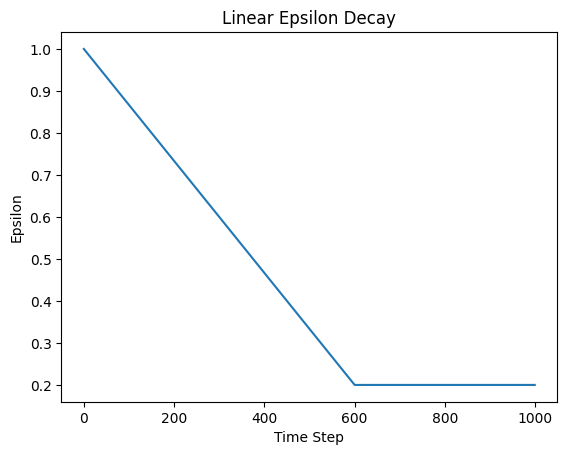

In [7]:
import matplotlib.pyplot as plt

eps_start = 1.0
eps_end = 0.2
schedule_duration = 1000

eps_values = [linear_epsilon_decay(eps_start, eps_end, t, 600) for t in range(schedule_duration)]

plt.plot(range(schedule_duration), eps_values)
plt.xlabel('Time Step')
plt.ylabel('Epsilon')
plt.title('Linear Epsilon Decay')
plt.show()
### BEGIN HIDDEN TESTS
assert eps_values[0] == eps_start, "Expected eps_values[0] to be eps_start"
assert eps_values[-1] == eps_end, "Expected eps_values[-1] to be eps_end"
assert len(eps_values) == schedule_duration, "Expected eps_values to have length schedule_duration"
assert np.abs(eps_values[300] - 0.6) < 1e-10, "Expected eps_values[600] to be 0.6"
assert eps_values[600] == 0.2, "Expected eps_values[600] to be 0.6"
### END HIDDEN TESTS


## 1.2 Target Network and Replay Buffer
As described before, the main idea behind DQN is simple, we just minimize the MSE between the TD-target and the current estimate using the transitions we sampled. However, there are two problems that make the method very unstable:

1. **Non-stationary target**: The TD-target uses an estimate from our Q-network. Unlike supervised learning, this target is not fixed, and whenever we update our network parameters, the target changes as well.
2. Sampled transitions are **correlated** (each transition depends on the last transition if both are from the same episode). Samples are not independent.

DQNs addresses both problems by using

1. **Target networks:**
An older set of network parameters is stored to compute the TD target, so they change less frequently and this improves stability. We call this network the target network. Its parameters are updated every few iterations.
2. **Experience Replay:**
A buffer where all transitions are stored and randomly sampled to make the data distribution more stationary. The buffer has a fixed size and new samples overwrite old ones.

First we look at the target network:

In [8]:
import torch
import torch.nn as nn
import copy

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, sigma_init=0.017):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))

        self.reset_parameters(sigma_init)

    def reset_parameters(self, sigma_init):
        bound = 1 / self.in_features**0.5
        self.weight_mu.data.uniform_(-bound, bound)
        self.bias_mu.data.uniform_(-bound, bound)
        self.weight_sigma.data.fill_(sigma_init)
        self.bias_sigma.data.fill_(sigma_init)

    def forward(self, x):
        # Sample noise
        weight_epsilon = torch.randn_like(self.weight_mu)
        bias_epsilon = torch.randn_like(self.bias_mu)

        # Noisy weights and biases
        weight = self.weight_mu + self.weight_sigma * weight_epsilon
        bias = self.bias_mu + self.bias_sigma * bias_epsilon

        return F.linear(x, weight, bias)

# Define a network with NoisyLinear
net = nn.Sequential(
    NoisyLinear(4, 3),
    nn.ReLU(),
    NoisyLinear(3, 1)
)

# Test input
test_input = torch.tensor([[1, 2, 3, 4]], dtype=torch.float32)
print(f"Prediction (Before): {net(test_input)}\n")

# Save the parameters
params = copy.deepcopy(net.state_dict())
print("Parameters:")
for key, value in params.items():
    print(f"- Parameter {key}:\n{value}")

# Modify `weight_mu` of the first layer to zero
net[0].weight_mu.data.fill_(0.0)
print(f"\nPrediction (After change): {net(test_input)}\n")

# Reload the saved parameters
net.load_state_dict(params)
print(f"Prediction (After reload): {net(test_input)}\n")


Prediction (Before): tensor([[0.6396]], grad_fn=<AddmmBackward0>)

Parameters:
- Parameter 0.weight_mu:
tensor([[ 0.4782, -0.1308, -0.3652,  0.4808],
        [-0.4353,  0.4579, -0.2473,  0.4488],
        [-0.0718, -0.4661,  0.3502, -0.4469]])
- Parameter 0.weight_sigma:
tensor([[0.0170, 0.0170, 0.0170, 0.0170],
        [0.0170, 0.0170, 0.0170, 0.0170],
        [0.0170, 0.0170, 0.0170, 0.0170]])
- Parameter 0.bias_mu:
tensor([ 0.0302,  0.4415, -0.1382])
- Parameter 0.bias_sigma:
tensor([0.0170, 0.0170, 0.0170])
- Parameter 2.weight_mu:
tensor([[-0.5367,  0.4409,  0.3315]])
- Parameter 2.weight_sigma:
tensor([[0.0170, 0.0170, 0.0170]])
- Parameter 2.bias_mu:
tensor([0.3126])
- Parameter 2.bias_sigma:
tensor([0.0170])

Prediction (After change): tensor([[0.4511]], grad_fn=<AddmmBackward0>)

Prediction (After reload): tensor([[0.6116]], grad_fn=<AddmmBackward0>)



So we can save and load old parameters of our network using ``.state_dict()`` and ``.load_state_dict(..)`` respectively.

---
<span style="color:orange">**Replay Buffer**</span>

The replay buffer stores transitions of the form $(s, a, r, s')$ with $s$ as the current state, the action $a$, the reward $r$, and the next state $s'$. The buffer can perform two operations:
- **store**: During sampling we observe transitions and store them with ``buffer.store(...)``. However, the buffer only has a fixed size
(as we cannot store an infinte amount of data). When reaching it, the oldest samples are overwritten first.
- **sample**: For training, we want to sample a batch of transitions from our buffer via ``buffer.sample(...)``. The transitions are sampled uniformly and with replacement i.e. the same transition can be sampled more than once.



In [9]:
class NStepReplayBuffer:
    def __init__(self, max_size: int, n_step: int = 3, gamma: float = 0.99):
        """
        Create the n-step replay buffer.

        :param max_size: Maximum number of transitions in the buffer
        :param n_step: Number of steps to accumulate rewards over
        :param gamma: Discount factor
        """
        """
        Create the n-step replay buffer.

        :param max_size: Maximum number of transitions in the buffer
        :param n_step: Number of steps to accumulate rewards over
        :param gamma: Discount factor
        """
        self.data = []
        self.max_size = max_size
        self.position = 0
        self.n_step = n_step
        self.gamma = gamma

        # Buffer for building n-step transitions
        self.temp_buffer = []

    def _get_n_step_info(self):
        """Calculate n-step reward and next state"""
        # Get the first (oldest) transition
        first = self.temp_buffer[0]

        # Calculate n-step reward
        n_step_reward = 0
        for i in range(self.n_step):
            if i >= len(self.temp_buffer):
                break
            n_step_reward += (self.gamma ** i) * self.temp_buffer[i][2]  # index 2 is reward

            # If episode terminated, don't include future rewards
            if self.temp_buffer[i][4]:  # index 4 is terminated flag
                break

        # Get the n-th next state and done flag
        if len(self.temp_buffer) >= self.n_step:
            next_state = self.temp_buffer[self.n_step - 1][3]  # index 3 is next_state
            done = self.temp_buffer[self.n_step - 1][4]
        else:
            next_state = self.temp_buffer[-1][3]
            done = self.temp_buffer[-1][4]

        return n_step_reward, next_state, done

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor,
              next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer.

        :param obs: The current observation
        :param action: The action
        :param reward: The reward
        :param next_obs: The next observation
        :param terminated: Whether the episode terminated
        """
        # Add transition to temporary buffer
        self.temp_buffer.append((obs, action, reward, next_obs, terminated))

        # If we have enough transitions, compute n-step transition
        if len(self.temp_buffer) >= self.n_step:
            n_step_reward, next_state, done = self._get_n_step_info()
            first_transition = self.temp_buffer[0]

            # Store the n-step transition
            transition = (
                first_transition[0],  # observation
                first_transition[1],  # action
                n_step_reward,        # n-step cumulative reward
                next_state,           # n-step next state
                done                  # done flag
            )

            if len(self.data) < self.max_size:
                self.data.append(transition)
            else:
                self.data[self.position] = transition

            self.position = (self.position + 1) % self.max_size

            # Remove the oldest transition
            self.temp_buffer.pop(0)

        # Clear temp buffer if episode terminated
        if terminated:
            while len(self.temp_buffer) > 0:
                n_step_reward, next_state, done = self._get_n_step_info()
                first_transition = self.temp_buffer[0]

                transition = (
                    first_transition[0],
                    first_transition[1],
                    n_step_reward,
                    next_state,
                    done
                )

                if len(self.data) < self.max_size:
                    self.data.append(transition)
                else:
                    self.data[self.position] = transition
                self.position = (self.position + 1) % self.max_size

                self.temp_buffer.pop(0)

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of n-step transitions.

        :param batch_size: The batch size
        :returns: Tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch)
        """
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]



## 1.3 Algorithm
In this section, we will first look at the update of the DQN and then implement the entire algorithm.

---
<span style="color:orange">**DQN Update**</span>


In [10]:
def update_dqn_nstep(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        n_step: int,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update the DQN network using n-step returns and Double Q-Learning.

    :param q: The DQN network
    :param q_target: The target DQN network
    :param optimizer: The optimizer
    :param gamma: The discount factor
    :param n_step: Number of steps for n-step return
    :param obs: Batch of current observations
    :param act: Batch of actions
    :param rew: Batch of n-step returns
    :param next_obs: Batch of n-step next observations
    :param tm: Batch of termination flags
    """
    # Zero out the gradient
    optimizer.zero_grad()

    # Calculate the n-step TD-Target using Double Q-Learning
    with torch.no_grad():
        # Use online network to SELECT action
        next_action = q(next_obs).argmax(dim=1)


        next_q_values = q_target(next_obs)
        next_q_value = next_q_values.gather(1, next_action.unsqueeze(1)).squeeze(1)


        td_target = rew + (gamma ** n_step) * next_q_value * (1 - tm.float())

    # Calculate current Q-values and loss
    current_q_values = q(obs)
    current_q_value = current_q_values.gather(1, act.unsqueeze(1))

    # Compute MSE loss
    loss = F.mse_loss(current_q_value, td_target.unsqueeze(1))

    # Backpropagate the loss and step the optimizer
    loss.backward()
    optimizer.step()

We are now putting it all together. This implementation is very similar to the Q-learning one. Note that we have not specified an environment yet! Our algorithm remains relatively flexible.

---
<span style="color:orange">**DQN Agent**</span>


In [11]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            n_step=3,  # Added parameter
        ):
            """
            Initialize the DQN agent.

            :param env: The environment
            :param gamma: The discount factor
            :param lr: The learning rate
            :param batch_size: Mini batch size
            :param eps_start: The initial epsilon value
            :param eps_end: The final epsilon value
            :param schedule_duration: The duration of the schedule (in timesteps)
            :param update_freq: How often to update the Q target
            :param maxlen: Maximum number of transitions in the buffer
            :param n_step: Number of steps for n-step returns
            """

            self.env = env
            self.gamma = gamma
            self.batch_size = batch_size
            self.eps_start = eps_start
            self.eps_end = eps_end
            self.schedule_duration = schedule_duration
            self.update_freq = update_freq
            self.n_step = n_step  # Store n_step as instance variable

            # Initialize the Replay Buffer with n_step parameter
            self.buffer = NStepReplayBuffer(maxlen, n_step=n_step, gamma=gamma)

            # Initialize the Deep Q-Network
            self.q = DQN(env.observation_space.shape, env.action_space.n)

            # Initialize the target network
            self.q_target = DQN(env.observation_space.shape, env.action_space.n)
            self.q_target.load_state_dict(self.q.state_dict())

            # Create an ADAM optimizer
            self.optimizer = optim.Adam(self.q.parameters(), lr=lr)

            self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)


    def train(self, num_episodes: int, min_buffer_size: int = 1000) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train
        :param min_buffer_size: Minimum number of transitions in buffer before starting updates
        :returns: The episode statistics
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()

            for episode_time in itertools.count():
                # Get current epsilon value
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                # Choose action and execute
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # Store sample in the replay buffer
                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )

                # Only start updating once we have enough samples
                if len(self.buffer) > min_buffer_size:
                    # Sample a mini batch from the replay buffer
                    obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)

                    # Update the Q network
                    update_dqn_nstep(
                        self.q,
                        self.q_target,
                        self.optimizer,
                        self.gamma,
                        self.n_step,
                        obs_batch.float(),
                        act_batch,
                        rew_batch.float(),
                        next_obs_batch.float(),
                        tm_batch
                    )

                    # Update the current Q target
                    if current_timestep % self.update_freq == 0:
                        self.q_target.load_state_dict(self.q.state_dict())

                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs

        return stats

## 1.4 Training
Now, we want to run our algorithm on a task in [MinAtar](https://github.com/kenjyoung/MinAtar). You are free to choose any environment you like, however, we recommend Breakout-v1 as the other environments may need different hyperparameters and more training time. The following game ID's are available: SpaceInvaders-v1, Breakout-v1, Seaquest-v1, Asterix-v1 and Freeway-v1.
Note, that the training can take several minutes.

In [12]:
# Choose your environment
env = gym.make('MinAtar/Breakout-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters
LR = 0.001
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 100
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 15_000
NUM_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99
N_STEP = 3

# Train DQN
agent = DQNAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    n_step=N_STEP,
)
stats = agent.train(NUM_EPISODES, min_buffer_size=1000)

Training on MinAtar/Breakout-v1
Observation space: Box(False, True, (10, 10, 4), bool)
Action space: Discrete(3)

Episode 100 of 1000  Time Step: 1038  Epsilon: 0.469
Episode 200 of 1000  Time Step: 2756  Epsilon: 0.417
Episode 300 of 1000  Time Step: 5194  Epsilon: 0.344
Episode 400 of 1000  Time Step: 7956  Epsilon: 0.261
Episode 500 of 1000  Time Step: 11982  Epsilon: 0.141
Episode 600 of 1000  Time Step: 16900  Epsilon: 0.050
Episode 700 of 1000  Time Step: 23152  Epsilon: 0.050
Episode 800 of 1000  Time Step: 29462  Epsilon: 0.050
Episode 900 of 1000  Time Step: 36152  Epsilon: 0.050
Episode 1000 of 1000  Time Step: 43424  Epsilon: 0.050


# 1.5 Results

Like in the last exercise, we will look at the resulting episode reward.

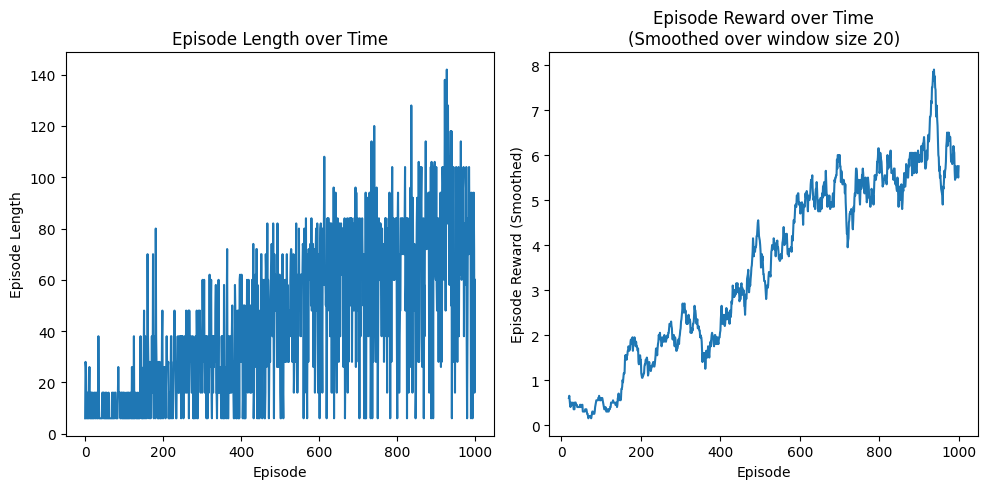

In [13]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

Lastly, let us see what the learned policy does in action.

/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:276: UserWarning: WARN: RGB-array rendering should return a numpy array with dtype uint8, got float64
  logger.warn(


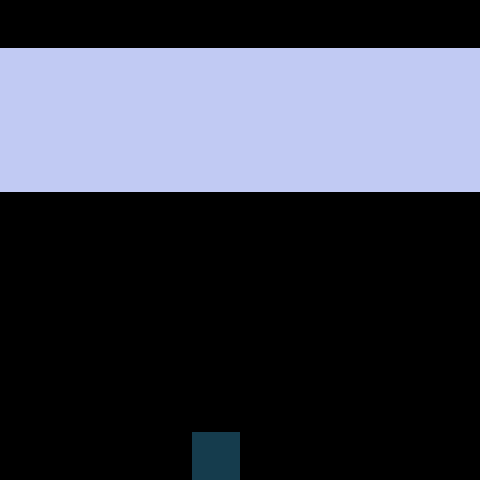

In [14]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")